# Evolutionary Algorithms

An example of evolutionary algorithms based on this blog: https://blog.sicara.com/getting-started-genetic-algorithms-python-tutorial-81ffa1dd72f9

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import sys
import matplotlib
libraries = (('Matplotlib', matplotlib), ('Numpy', np))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1


So we want to build an algorithm that can explore all the possibilities and then figure out what the right answer is. In this example, we'll say that we are trying to guess someone's password - but the only thing we can test is, "given my guess, how many of the characters are in the right place compared to the true password?" This is a bit of a contrived example, since in this case we have to know the answer to find the answer - but it's a great way to learn. To explore this, we're going to use an evolutionary algorithm. The idea here is that it follows a few steps:

1. We create a generation of guesses
2. We find out which are the best guesses
3. We "breed" those guesses to propogate forward their "good genes"
4. We add in some diversity by including some bad guesses, so we don't accidentally get trapped in a loop of always guessing the same things
5. We repeat this over many generations of "parents and children" until we see an answer.

So let's get started with some ground rules:

- Our passwords are alpha numeric. They can only use a-z, A-Z, 0-9 as characters
- The password for the first round will be 10 characters long (we'll try to use a bigger one later)

In [119]:
import string
allowed_characters = list(string.printable[:62])+[' ']
print(allowed_characters)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ']


In [120]:
np.random.seed(42)
def create_guess(length):
    guess = [np.random.choice(allowed_characters) for _ in range(length)]
    return ''.join(guess)

create_guess(10)

'CPseG7YkCV'

In [121]:
def create_generation(population=100, length=10):
    generation = [create_guess(length) for _ in range(population)]
    return generation

test_generation = create_generation(population=10, length=10)
print(test_generation)

['imaanQzDn2', 'lQ1nHtB1Xk', 'wbVlYHoMqW', ' FrXfeZZKZ', 'OHSPU2AO6k', '8Ch3oXdNV8', 'pQ1jrKX6HY', '7KydgzND31', 'Z5RF3Rs hp', 'Hx9ZzduLe7']


Now we need a function to define how "good" these guesses are, because we want to strongest to surive. In this case, we'll just make a simple function that scores them on how many of the characters are in the correct position. In evolutionary algorithm parlance, this is called a fitness function.

In [122]:
def fitness_score(guess, actual):
    """
    a simple function that scores them on how many of the characters are in the correct position.
    1 point is awarded per correct character in correct position.
    """
    score = 0
    for i,j in zip(guess, actual):
        if i==j:
            score+=1
    return score

def check_fitness(guesses, actual):
    """
    Goes through every guess and calculates the fitness score. 
    Returns a list of tuples: (guess, fitness_score)
    """
    fitness_indicator = []
    for guess in guesses:
        fitness_indicator.append((guess, fitness_score(guess, actual)))
    return fitness_indicator

print(check_fitness(test_generation, 'imbobandhi'))

[('imaanQzDn2', 2), ('lQ1nHtB1Xk', 0), ('wbVlYHoMqW', 0), (' FrXfeZZKZ', 0), ('OHSPU2AO6k', 0), ('8Ch3oXdNV8', 0), ('pQ1jrKX6HY', 0), ('7KydgzND31', 0), ('Z5RF3Rs hp', 1), ('Hx9ZzduLe7', 0)]


So we see that `imaanQzDn2` shares the first two letters with `imbobandhi` so it gets a score of 2. `Ch3oXdNV8p` shares the `o` with `imbobandhi` so it gets a score of 1. Nice, our fitness function is working. So we can check off steps 1 and 2 - create a generation and test their strength (or fitness).

Now we need to setup a breeding program. So what does that entail? Per the blog, the best method is to take the strongest N guesses, plus some random ones for genetic diversity, and then do the breeding. The simplest way to do the breeding is to go character by character and randomly choose from between two parents. Let's see what that looks like.

In [123]:
def get_breeders_from_generation(guesses, actual, take_best_N=10, take_random_N=5, verbose=False, mutation_rate=0.1):
    """
    This sets up the breeding group for the next generation. You have
    to be very careful how many breeders you take, otherwise your
    population can explode. These two, plus the "number of children per couple"
    in the make_children function must be tuned to avoid exponential growth or decline!
    """
    # First, get the top guesses from last time
    fit_scores = check_fitness(guesses, actual)
    sorted_guesses = sorted(fit_scores, key=lambda x: x[1], reverse=True)
    new_generation = [x[0] for x in sorted_guesses[:take_best_N]]
    best_guess = new_generation[0]
    
    if verbose:
        # If we want to see what the best current guess is!
        print(best_guess)
    
    # Second, get some random ones for genetic diversity
    for _ in range(take_random_N):
        new_generation.append(np.random.choice(guesses))
        
    # Third, add any mutations
    guess_indexes = list(range(len(actual)))
    for guess in new_generation:
        if np.random.uniform() < mutation_rate:
            gs = list(guess)
            gs[np.random.choice(guess_indexes)] = np.random.choice(allowed_characters)
            guess = ''.join(gs)
    
    np.random.shuffle(new_generation)
    return new_generation, best_guess

def make_child(parent1, parent2):
    """ 
    Randomly select parent 1 or parent 2 for each character and give
    the child the "gene" from that parent.
    """
    child = list(parent1)
    parent2 = list(parent2)
    for ix, gene in enumerate(child):
        if np.random.uniform() >= 0.5:
            child[ix] = parent2[ix]
    return ''.join(child)

def make_children(old_generation, children_per_couple=1):
    """
    Pairs parents together, and makes children for each pair. 
    If there are an odd number of parent possibilities, one 
    will be left out. 
    
    Pairing happens by pairing the first and last entries. 
    Then the second and second from last, and so on.
    """
    mid_point = len(old_generation)//2
    next_generation = [] 
    
    for ix, parent in enumerate(old_generation[:mid_point]):
        for _ in range(children_per_couple):
            next_generation.append(make_child(parent, old_generation[-ix-1]))
    return next_generation

In [124]:
make_child('steveisfish','lauranobird')

'lauranobish'

Let's look at a test cycle with our test_generation.

In [125]:
breeders, _ = get_breeders_from_generation(test_generation, 'imbobandhi')
print(breeders)

['7KydgzND31', 'wbVlYHoMqW', '8Ch3oXdNV8', 'pQ1jrKX6HY', '7KydgzND31', 'Z5RF3Rs hp', 'Hx9ZzduLe7', 'Z5RF3Rs hp', 'Z5RF3Rs hp', ' FrXfeZZKZ', 'pQ1jrKX6HY', 'imaanQzDn2', 'lQ1nHtB1Xk', 'imaanQzDn2', 'OHSPU2AO6k']


In [126]:
print(make_children(breeders, children_per_couple=2))

['7KyPg2AD6k', '7HSPU2ND31', 'wmVlYQoDqW', 'wbalnHoMq2', '8Ch3Htd1Vk', '8ChnHtd1X8', 'pQajnKzDH2', 'im1jnQX6nY', 'pQ1jgKXD3Y', 'pK1jrKNDHY', ' 5rXfeZZhZ', ' 5RF3es hp', 'H5RZ3RsLhp', 'H59Z3RsLep']


Sweet, it looks like our parents features are being carried on, but aren't being directly copies. So all is going how we hoped for now. Now let's try actually solving the problem by letting many generations happen and turning up how many guesses there are in the initial generation. We'll also change the password here to something easier to tell whether the algorithm is working.

In [127]:
current_generation = create_generation(population=500, length=10)
actual_password = 'passwordhi'
print_every_n_generations = 5

for i in range(1000):
    if not i % print_every_n_generations:
        print("Generation %i: "%i, end='')
        print(len(current_generation))
        is_verbose = True
    else:
        is_verbose = False
    breeders, best_guess = get_breeders_from_generation(current_generation, actual_password, 
                                                        take_best_N=250, take_random_N=100, 
                                                        verbose=is_verbose)
    if best_guess == actual_password:
        print("Got the password in %i generations. It's %s"%(i,best_guess))
        break
    current_generation = make_children(breeders, children_per_couple=3)
    

Generation 0: 500
pEy PopaB1
Generation 5: 525
pIaswoq5hA
Generation 10: 525
passwoLdhi
Got the password in 12 generations. It's passwordhi


Let's put this into a function so we can repeat it with different sets of stuff.

In [154]:
def evolve_to_solve(current_generation, actual_password, max_generations, take_best_N, take_random_N,
                    mutation_rate, children_per_couple, print_every_n_generations, verbose=False):
    fitness_tracking = []
    for i in range(max_generations):
        if verbose and not i % print_every_n_generations:
            print("Generation %i: "%i, end='')
            print(len(current_generation))
            is_verbose = True
        else:
            is_verbose = False
        breeders, best_guess = get_breeders_from_generation(current_generation, actual_password, 
                                                            take_best_N=take_best_N, take_random_N=take_random_N, 
                                                            verbose=is_verbose, mutation_rate=mutation_rate)
        fitness_tracking.append(fitness_score(best_guess, actual_password))
        if best_guess == actual_password:
            print("Got the password in %i generations. It's '%s'"%(i,best_guess))
            return fitness_tracking
        current_generation = make_children(breeders, children_per_couple=children_per_couple)
    
    print("Couldn't get the password. My best guess is '%s'"%(best_guess))
    return fitness_tracking

current_generation = create_generation(population=500, length=10)
fitness_tracking = evolve_to_solve(current_generation, 'imbobandhi', 1000, 150, 70, 0.5, 3, 5, verbose=True)

Generation 0: 500
1UUBbxS3hz
Generation 5: 330
1mhoraKdFi
Generation 10: 330
imbobatdhi
Got the password in 12 generations. It's 'imbobandhi'


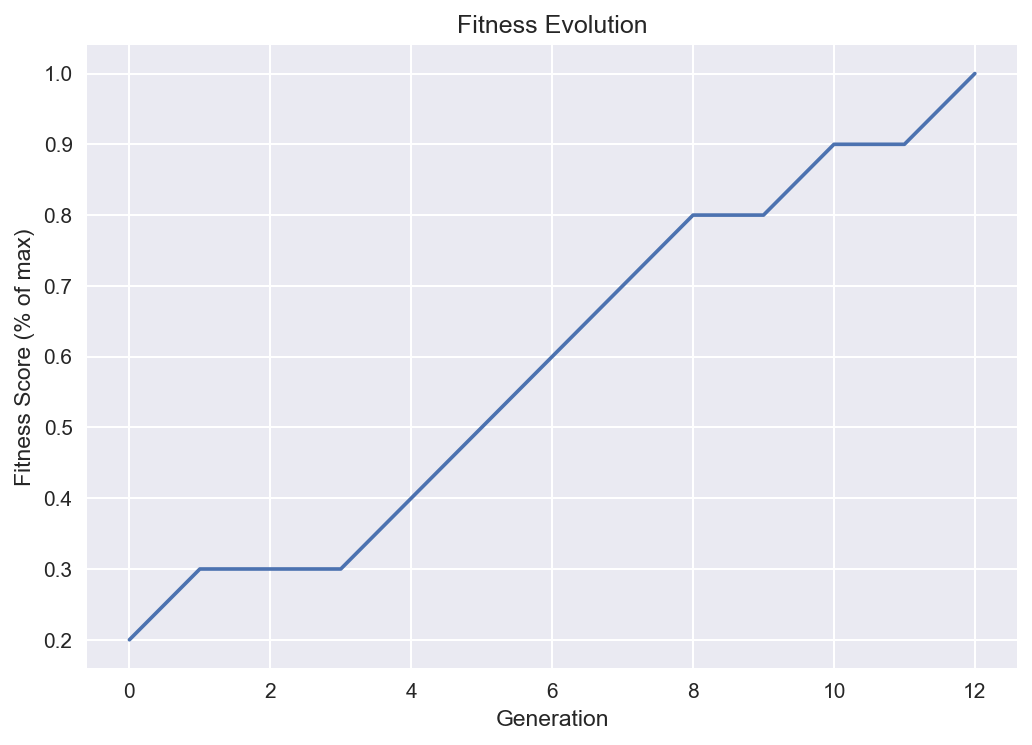

In [161]:
def make_fitness_tracking_plot(fitness_tracking, actual_pass):
    plt.figure(dpi=150)
    plt.plot(range(len(fitness_tracking)), [x/len(actual_pass) for x in fitness_tracking])
    plt.ylabel("Fitness Score (% of max)")
    plt.xlabel("Generation")
    plt.title("Fitness Evolution");

make_fitness_tracking_plot(fitness_tracking, 'imbobandhi')

In [162]:
actual_pass = 'lets see if it can do a whole sentence'
current_generation = create_generation(population=1000, length=len(actual_pass))
fitness_tracking2 = evolve_to_solve(current_generation, actual_pass, 1000, 350, 100, 0.5, 3, 5, verbose=True)

Generation 0: 1000
NCQcUPXeOiVXEMriJCEdOyFRQe7xQDlmCKgnrD
Generation 5: 675
hF7SisDeEHfsntb4089oowyCZtpFg0seJZeCwA
Generation 10: 675
Lqtn zfx ip itKz4dadQVa QuKledZentWzcH
Generation 15: 675
lAXs seeMiffitbban ooa0 wNo4eqsentWnVe
Generation 20: 675
lets sVe if it can xoga whW3e nentenSe
Generation 25: 675
lets see if it cPn do a whole sentence
Got the password in 27 generations. It's 'lets see if it can do a whole sentence'


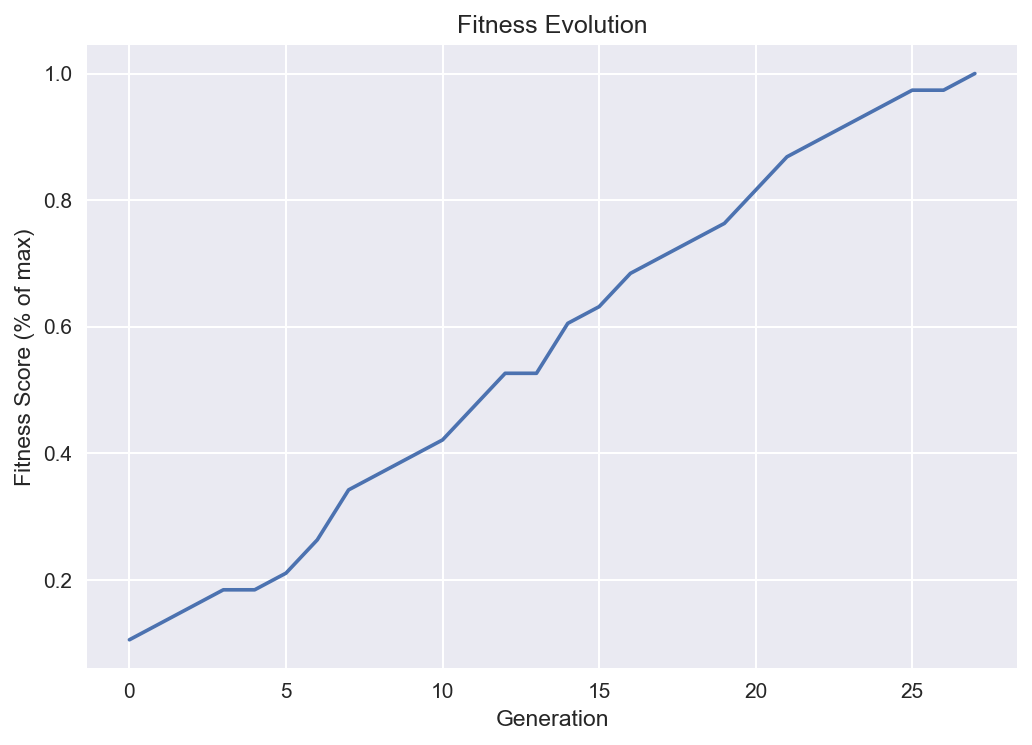

In [163]:
make_fitness_tracking_plot(fitness_tracking2, actual_pass)

Neat! What if we give it a significantly harder problem?

In [167]:
actual_pass = """
It was the best of times it was the worst of times it was the age of wisdom it was the age of foolishness 
it was the epoch of belief it was the epoch of incredulity it was the season of Light it was the season of Darkness 
"""
actual_pass = actual_pass.replace('\n','')

In [168]:
current_generation = create_generation(population=1000, length=len(actual_pass))
fitness_tracking3 = evolve_to_solve(current_generation, actual_pass, 1000, 350, 100, 0.5, 3, 50, verbose=True)

Generation 0: 1000
wpvxDArUco1mj42IktEPdrYM5sG5UbpJZ9BteGrq2iy15tIsMtu3rJTmdL6ZK 6MifxqZE3UxN16kftndsXZTqCASO sEnMBoisQSSDjrah elr8cMYs8OTkcFASG83hhPuoRVj aArxtw05UpHs6 inTSsiksoyJoBlli87rcDYfPeq82aad9DoCrXzrCn6IiTVj 1qne6VsXLJne6VziUtC9TKuQ
Generation 50: 675
It wl5 8Je  e4t oU xi3es4StDwes tjq wyrstusTHiimeS itDqGn th0 ayp qf wDsdKy ItIKBsiRh9 age Tf fo9lEKhne2s it was thxlepochNof bIlJeJ itIwas the e9lchJmf increduWity itWwasTt7MgsXasm2 Bf Light0it wTs theqs3uwonsof Iarkness 
Generation 100: 675
It w8s the best of timesgitCwas the worst6o4 times ituwas the afe of wisdom ct80asiXh5 age of foolmHhness it was the epoch of bblief itIwas the epZch of increduWity it3was theaseasoG of Light it wMs the season of Darkness 
Generation 150: 675
It wYs the best of timesmitCwas the worstZoP times itvwas the afe of wisdom stLfasCGhW age of foolRQhness it was the epoch of bblief itiwas the epZch of incredu2ity it3was theLseasoG of Light it wMs the season of Darkness 
Generation 200: 675
It wYs the

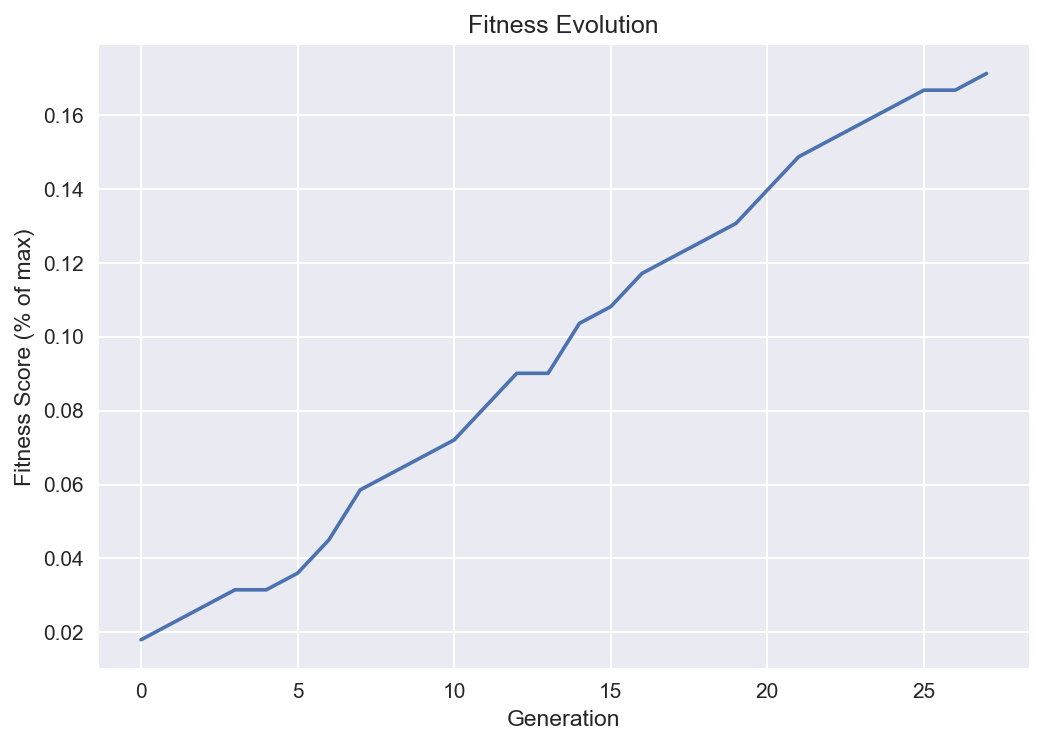

In [169]:
make_fitness_tracking_plot(fitness_tracking2, actual_pass)

Looks like it's still making good progress, but not as fast as we'd like. Let's tune some of the parameters. (I'll just show the best result I can get)

In [170]:
current_generation = create_generation(population=2000, length=len(actual_pass))
fitness_tracking4 = evolve_to_solve(current_generation, actual_pass, 2000, 500, 200, 0.5, 4, 100, verbose=True)

Generation 0: 2000
pPoc9io47mLy0JoWhTTqtEpUMPOIH8BQoG n5I4c5Jysjf8p9eiGHhhyDhWRTxMoeqovefiUoMrZE5qWPfztWaZUeiPohaP7jEiOLErMmG3dbRZPCI2dlWlzTuX HVS VRY4VA1 LnsGQD0TWrruQcMpPw4IuNdKXRzCvEr7kLBvFjZi5cA3su R9CAHYctqMw9Jxa1njxHuhJYPo8IEheUnm1FK74
Generation 100: 1400
GW was thx best of times it was ghe worst of timesKit was the age of wisdom it was the age of foolishness it was the epoch of belief it was the epoch of incredulity it was the season of Light it was the season of Aarkness 
Generation 200: 1400
WH was thr best of times it was She worst of timesmit was the age of wisdom it was the age of foolishness it was the epoch of belief it was the epoch of incredulity it was the season of Light it was the season of Carkness 
Generation 300: 1400
US was thK best of times it was ghe worst of timesmit was the age of wisdom it was the age of foolishness it was the epoch of belief it was the epoch of incredulity it was the season of Light it was the season of parkness 
Generation 400: 1400
sS wa

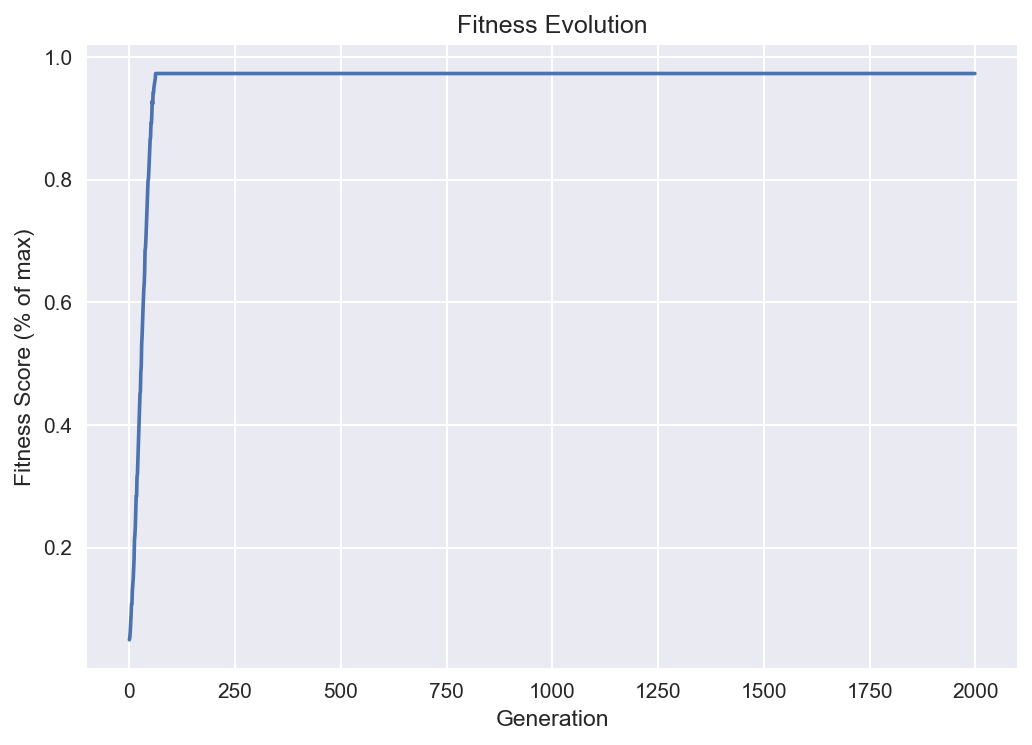

In [171]:
make_fitness_tracking_plot(fitness_tracking4, actual_pass)

Nice, it's getting really close. We might just need to update our mutation function to allow more mutations, that way it can help it kick out of these local minima that it's getting stuck in. Let's try making it so each character has a small chance of switching. It's more computationally expensive, but should help fight getting stuck like this.

In [184]:
def get_breeders_from_generation(guesses, actual, take_best_N=10, take_random_N=5, verbose=False, mutation_rate=0.01):
    """
    This sets up the breeding group for the next generation. You have
    to be very careful how many breeders you take, otherwise your
    population can explode. These two, plus the "number of children per couple"
    in the make_children function must be tuned to avoid exponential growth or decline!
    """
    # First, get the top guesses from last time
    fit_scores = check_fitness(guesses, actual)
    sorted_guesses = sorted(fit_scores, key=lambda x: x[1], reverse=True)
    new_generation = [x[0] for x in sorted_guesses[:take_best_N]]
    best_guess = new_generation[0]
    
    if verbose:
        # If we want to see what the best current guess is!
        print(best_guess)
    
    # Second, get some random ones for genetic diversity
    for _ in range(take_random_N):
        new_generation.append(np.random.choice(guesses))
        
    # Third, add any mutations
    guess_indexes = list(range(len(actual)))
    for guess in new_generation:
        guess = list(guess)
        for i,character in enumerate(guess):
            if np.random.uniform() < mutation_rate:
                guess[i] = np.random.choice(allowed_characters)
        guess = ''.join(guess)
    
    np.random.shuffle(new_generation)
    return new_generation, best_guess

In [186]:
actual_pass = 'lets see if it can do a whole sentence'
current_generation = create_generation(population=1000, length=len(actual_pass))
fitness_tracking2 = evolve_to_solve(current_generation, actual_pass, 1000, 350, 100, 0.5, 3, 5, verbose=True)

Generation 0: 1000
lTtEbUqehi5Gc6DuaX8X0uuxg4BJ7FxIc2R8uv
Generation 5: 675
bzl9 Qe8CgpmRkuEasEdWVq w8o3BFmRnP6icE
Generation 10: 675
lBtk De2JifwiSJopn9UI a wh8VMfO6nOenYe
Generation 15: 675
T5ts seJ if AjYcan do C wh6leGseby6ncx
Generation 20: 675
lets seeK5f it can do o whole5j3jaence
Generation 25: 675
lets seeaif iH can do a whole sentence
Got the password in 29 generations. It's 'lets see if it can do a whole sentence'


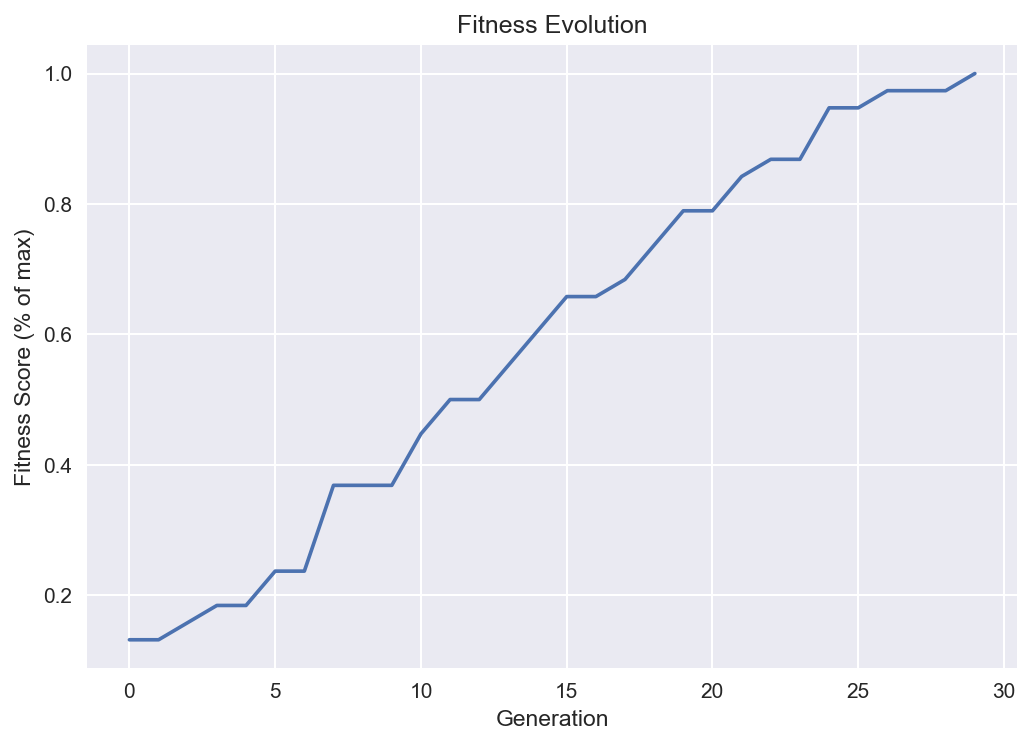

In [187]:
make_fitness_tracking_plot(fitness_tracking2, actual_pass)

In [191]:
actual_pass = """
It was the best of times it was the worst of times it was the age of wisdom it was the age of foolishness 
it was the epoch of belief it was the epoch of incredulity it was the season of Light it was the season of Darkness 
"""
actual_pass = actual_pass.replace('\n','')
current_generation = create_generation(population=2000, length=len(actual_pass))
fitness_tracking4 = evolve_to_solve(current_generation, actual_pass, 1000, 700, 200, 0.1, 8, 100, verbose=True)

Generation 0: 2000
VxDkuuSzyQOkpJgK0WVWjLPW1tet9ajJJPTDup0Ir92cFWNRArhatbyzB1NFNHvNqg9DLGvn8SaJo3TrKNPrr2i562P1cKKyopipksBWEz7d 62Th lms3OWyhA82yWbzbLqNpLK7mYD5aXHoUCFZgV5gq12VYVUrbergPPIZvqoshQJjk5OxOfFrMFZfhKxSQT24FfZhPno8Js9LDSz 90epxeShu
Generation 100: 3600
It was the best of times it was the worst oO times it was the age of wisdom it was the age of foolishness it was thegepoch of belief it was the epoch of incredulity it was the season of Light it was the season of Darkness 
Generation 200: 3600
It was the best of times it was the worst os times it was the age of wisdom it was the age of foolishness it was theHepoch of belief it was the epoch of incredulity it was the season of Light it was the season of Darkness 
Generation 300: 3600
It was the best of times it was the worst on times it was the age of wisdom it was the age of foolishness it was theHepoch of belief it was the epoch of incredulity it was the season of Light it was the season of Darkness 
Generation 400: 3600
It wa

[0.990990990990991, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.990990990990991]


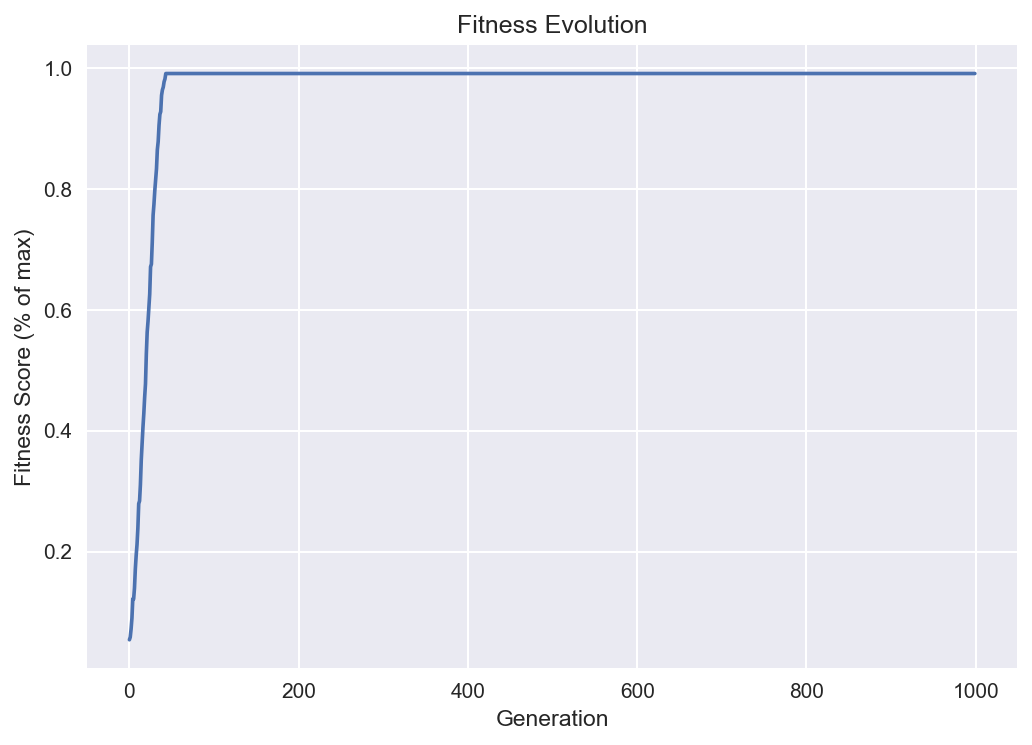

In [194]:
make_fitness_tracking_plot(fitness_tracking4, actual_pass)
print([x/len(actual_pass) for x in fitness_tracking4[-10:]])